# Redes neuronales para la serie de tiempo de Exportaciones

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.14.0
Pandas Version: 1.5.3
Numpy Version: 1.23.5
System Version: 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]


In [3]:
import IPython
import IPython.display

## Datos: Serie de tiempo del total de exportaciones de Colombia 2000 - 2023

In [5]:
# Lectura de la serie
Exportaciones = pd.read_excel("C:/Users/dofca/Desktop/series/datos/Exportaciones.xlsx",
                   header = 0, usecols = ['Mes','Total']).iloc[96:].reset_index(drop = True).round()
Exportaciones['Total'] = Exportaciones['Total'].astype(int) 
Exportaciones

,Mes,Total
0,2000-01-01,1011676
1,2000-02-01,1054098
2,2000-03-01,1053546
3,2000-04-01,886359
4,2000-05-01,1146258
...,...,...
277,2023-02-01,4202234
278,2023-03-01,4431911
279,2023-04-01,3739214
280,2023-05-01,4497862


## Predicción Univariada

Se desea predecir la variable total de exportaciones **(Total)** usando los retardos de ella misma.

In [6]:
features_considered = ['Total'] # la variable a usar en la predicción es ella misma

In [7]:
features = Exportaciones[features_considered] # solo se usará la variable Total en la predicción
features.index = Exportaciones['Mes'] # variable que indica el tiempo (la serie es mensual)
features.head()

,Total
Mes,
2000-01-01,1011676
2000-02-01,1054098
2000-03-01,1053546
2000-04-01,886359
2000-05-01,1146258


array([<Axes: xlabel='Mes'>], dtype=object)

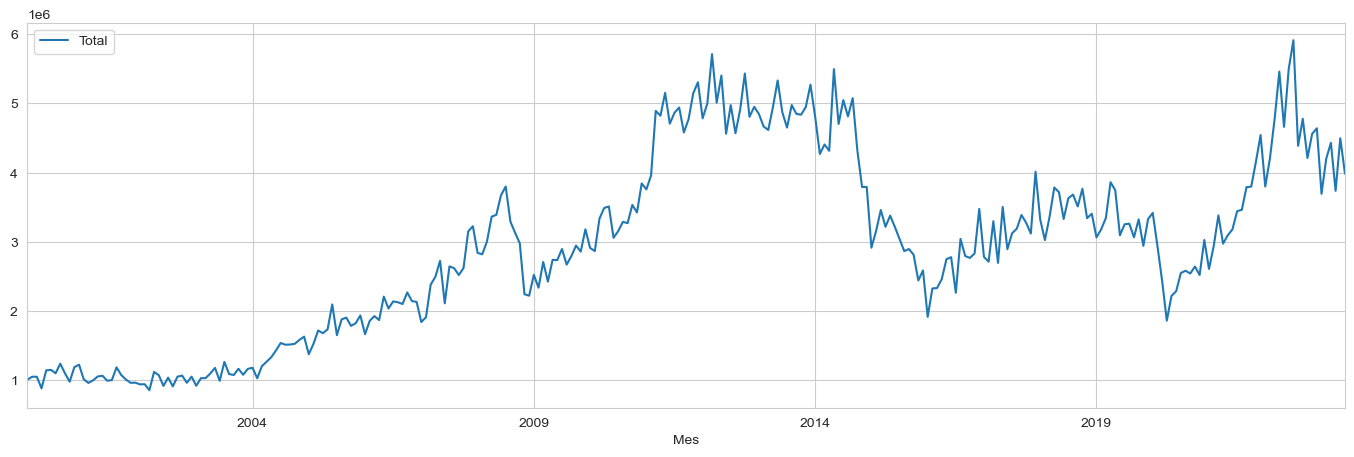

In [8]:
features.plot(subplots = True) # gráfico de la serie de tiempo

## Separación (Entrenamiento-Validación-Prueba) y Normalización.

In [9]:
# partición del conjuntos de datos en entrenamiento, validación y prueba
column_indices = {name: i for i, name in enumerate(features.columns)} # índice = 0

n = len(features) # longitud de la serie (282)
train_df = features[0:int(n*0.7)] # 2000-01 hasta 2016-05
val_df = features[int(n*0.7):int(n*0.9)] # 2016-06 hasta 2021-01
test_df = features[int(n*0.9):] # 2021-02 hasta 2023-06

num_features = features.shape[1]

In [10]:
print("longitud dataframe entrenamiento:", train_df.shape)
print("longitud dataframe validación:", val_df.shape)
print("longitud dataframe prueba:", test_df.shape)

longitud dataframe entrenamiento: (197, 1)
longitud dataframe validación: (56, 1)
longitud dataframe prueba: (29, 1)


In [11]:
# Normalización de las observaciones
# StandardScalar de sklearn
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [12]:
# todo el dataframe normalizado por train_mean y train_std
df_std = (features - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
df_std

,Column,Normalized
0,Total,-1.172383
1,Total,-1.142863
2,Total,-1.143247
3,Total,-1.259587
4,Total,-1.078732
...,...,...
277,Total,1.047816
278,Total,1.207640
279,Total,0.725616
280,Total,1.253533


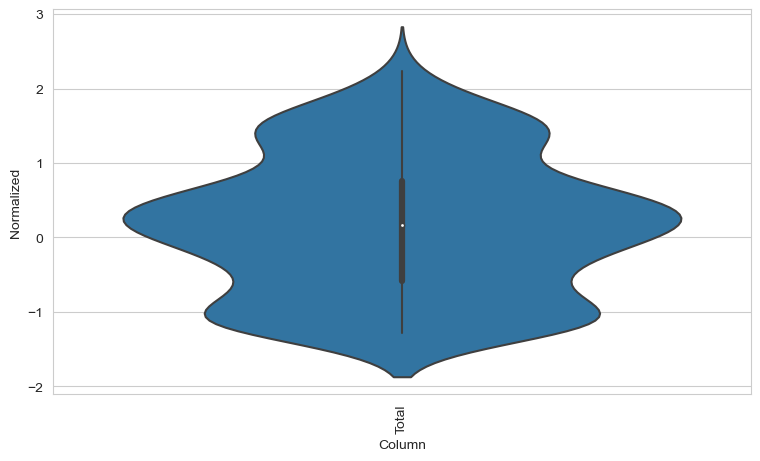

In [13]:
plt.figure(figsize=(9, 5))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
_ = ax.set_xticklabels(features.keys(), rotation=90)

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Split

Dada una lista de entradas consecutivas, el método split_window las convertirá en una ventana de entradas y una ventana de etiquetas.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## Transforma nuestros objetos a tipo tensorflow
Tamaño del lote batch size = 32

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,) 

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Definir las gráficas para visualizar lo que se desea predecir en términos de las entradas

In [ ]:
def plot(self, model=None, plot_col='Total', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

# Configuración para el ajuste de los modelos

In [ ]:
# Definimos número de épocas necesarias y funciones de pérdida
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2): #patiences como el número de épocas que espera antes de parar
  # Para evitar sobreajuste
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

--------------------------------------------------

--------------------------------------------------

# Modelos para predecir (1 paso adelante)

## 1. Modelo base (Naive)

In [ ]:
# configuración del modelo base
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Total'])
single_step_window

In [ ]:
# Ejemplo de cómo se itera sobre los lotes en los tres datasets
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
# modelo base. Retorna como predicción del siguiente paso, la predicción actual.
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Se entrena el modelo usando el conjunto de datos **single_step_window**.

In [ ]:
baseline = Baseline(label_index=column_indices['Total'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Se crea una ventana amplia para visualizar el comportamiento del modelo:

In [ ]:
wide_window = WindowGenerator(
    input_width=12, label_width=12, shift=1,
    label_columns=['Total'])
wide_window

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(baseline)

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

## 2. Modelo lineal

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

In [ ]:
history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

In [ ]:
wide_window.plot(linear)

## 3. Modelo  perceptrón multicapa (MLP) con dos capas ocultas y usando función de activación RELU

In [ ]:
single_step_window

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
dense.evaluate(single_step_window.test,verbose=1)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [ ]:
single_step_window.plot(dense)

## 4. Modelo  perceptrón multicapa (MLP) con múltiples retardos incluídos 
Se usarán 6 retardos para predecir el valor de la serie un paso adelante.

In [ ]:
CONV_WIDTH = 6
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Total'])
conv_window

In [ ]:
conv_window.plot()
plt.title("A partir de los 6 meses pasados, predecir el siguiente el valor para el siguiente mes")
plt.tight_layout()

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Ejemplo de cómo se itera sobre los lotes:

In [ ]:
conv_window.example[0]

In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

In [ ]:
conv_window.plot(multi_step_dense)

## 5. Modelo  perceptrón multicapa (MLP) con múltiples retardos incluídos a través de una convolución 


In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(conv_model, conv_window)
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

In [ ]:
LABEL_WIDTH = 12
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Total'])
wide_conv_window

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

In [ ]:
wide_conv_window.plot(conv_model)

## Red neuronal recurrente (LSTM) con múltiples retardos incluídos 

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(lstm_model)

## Evaluación de los modelos

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]
plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend() 

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

In [ ]:
dense.evaluate(single_step_window.test,verbose=1)

In [ ]:
conv_model.evaluate(conv_window.test,verbose=1)

In [ ]:
unpaso_con6meses = WindowGenerator(
    input_width=6, label_width=1, shift=1,
    label_columns=['Total'])# La variable a predecir es T Total
unpaso_con6meses

In [ ]:
for example_inputs, example_labels in unpaso_con6meses.train.take(1):
  print(f'Forma(dimensión) de las entradas (batch, time, features): {example_inputs.shape}')
  print(f'Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): {example_labels.shape}')

In [ ]:
unpaso_con6meses.plot()

# Ejemplo de los datos que conforman los dos primeros lotes para los datos de entrenamiento y prueba

In [ ]:
i=1
for batch in unpaso_con6meses.train.take(7):
    inputs, targets = batch
    print("Covariable o input del lote",i,inputs)
    print("Respuesta o etiqueta del lote ",i,targets)
    print("tipo de objeto inputs del lote",i,type(inputs))
    i=i+1

In [ ]:
i=1
for batch in unpaso_con6meses.val.take(2):
    inputs, targets = batch
    print("Covariable o input del lote",i,inputs)
    print("Respuesta o etiqueta del lote ",i,targets)
    print("tipo de objeto inputs del lote",i,type(inputs))
    i=i+1

In [ ]:
i=1
for batch in unpaso_con6meses.test.take(2):
    inputs, targets = batch
    print("Covariable o input del lote",i,inputs)
    print("Respuesta o etiqueta del lote ",i,targets)
    print("tipo de objeto inputs del lote",i,type(inputs))
    i=i+1

# Tamaño del conjunto de datos de entrenamiento, validación y prueba

In [ ]:
dataset_train_len = len(list(unpaso_con6meses.train.unbatch().map(lambda x, y: (x, y))))
dataset_val_len = len(list(unpaso_con6meses.val.unbatch().map(lambda x, y: (x, y))))
dataset_test_len = len(list(unpaso_con6meses.test.unbatch().map(lambda x, y: (x, y))))
print("longitud datos de entrenamiento:",dataset_train_len)
print("longitud datos de validación:",dataset_val_len)
print("longitud datos de prueba:",dataset_test_len)

# Crear objeto tensorflow

In [ ]:
unpaso_con6meses.train.element_spec

In [ ]:
for example_inputs, example_labels in unpaso_con6meses.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

## Modelo base

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

### se entrena el modelo usando el conjunto de datos (unpaso_con6meses)

In [ ]:
baseline = Baseline(label_index=column_indices['Total'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(unpaso_con6meses.val)
performance['Baseline'] = baseline.evaluate(unpaso_con6meses.test, verbose=0)

# Evaluación del modelo base en una ventana grande.

In [ ]:
wide_window = WindowGenerator(
    input_width=6, label_width=6, shift=1, label_columns=['Total'])

wide_window

In [ ]:
wide_window.plot(baseline)

In [25]:
x = [1, 2, 3, 4, 5]
for i in x:
    print(i)
    if i == 4:
        break

1
2
3
4
